لطفا در صورت امکان برای اطمینان از اجرای بدون مشکل، کد را در کولب، که در لینک زیر آمده است، اجرا کنید.

# Panorama

[فولدر درایو خروجی‌ها](https://drive.google.com/drive/folders/1uVXLxQrr_U1xnON8yKpdbrGdw3aJ6u5T?usp=sharing)

توجه: کدهای این نتبوک روی گوگل کولب توسعه یافته و تست شده است  
همچنین، لایبرری $opencv$ استفاده شده، به طور جداگانه بیلد شده است زیرا از روش $SURF$ که در بیلد معمولی نیست استفاده شده‌است   

فایل لایبرری در فولدر درایو خروجی‌های کد آمده است  
[Link to cv build](https://drive.google.com/file/d/1T6F9JeEPd42QN_5oAQbG0oeTTCZh3Hlq/view?usp=sharing)  

برای استفاده از لایبرری، آن‌را در کنار کد قرار دهید و اجرا کنید  

[Link to Origianl Colab Notebook](https://colab.research.google.com/drive/1D1UpRE-qiaH4_Y7ytBjWOq4vReIrAy7I?usp=sharing)  

می‌توانید فولدر بالا را در درایو خود کلون کنید و کد زیر را اجرا کنید که درایو شما را مانت میکند و لایبرری را در رانتایم لود می‌کند



## OpenCV and GPU Init

In [ ]:
!apt update

!apt install libjpeg-dev libpng-dev libtiff-dev
!apt install libavcodec-dev libavformat-dev libswscale-dev libavresample-dev
!apt install libgstreamer1.0-dev libgstreamer-plugins-base1.0-dev
!apt install libxvidcore-dev x264 libx264-dev libfaac-dev libmp3lame-dev libtheora-dev 
!apt install libfaac-dev libmp3lame-dev libvorbis-dev
!apt-get install python3-dev python3-pip
!apt-get install libtbb-dev
!apt-get install libatlas-base-dev gfortran
!apt-get install libprotobuf-dev protobuf-compiler
!apt-get install libgoogle-glog-dev libgflags-dev
!apt-get install libgphoto2-dev libeigen3-dev libhdf5-dev doxygen

!pip3 uninstall -y numpy
!pip3 install 'numpy>=1.20'

بعد از اجرای سلول بالا، رانتایم را ری‌استارت کنید و سپس ادامه دهید  

در صورتی که تمایل دارید کد را روی کولب اجرا کنید، می‌توانید دو سلول زیر را اجرا کنید تا لایبرری از درایو شما خوانده شود

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp "/content/drive/MyDrive/hw2-out/cv2.cpython-37m-x86_64-linux-gnu.so" .

قسمت‌هایی از این  کد برای سرعت بیشتر با جی‌پی‌یو نوشته شده‌است که می‌توان آن‌را فعال کرد ولی الزامی نیست زیرا کد معادل آن برای سی‌پی‌یو نیز نوشته شده است   

البته این بیلد، برای جی‌پی‌یو های دیتاسنتر گوگل است. برای استفاده از کد‌های جی‌پی‌یو بر روی کامپیوتر شخصی باید جداگانه بیلد شود۰

کد زیر برای بررسی کارت‌گرافیکی‌ست

In [5]:
!nvidia-smi

Tue May 11 17:03:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     6W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!cp './drive/MyDrive/hw2-out/video.mp4' './video.mp4'

حال لایبرری را ایمپورت کرده و سپس به عنوان تست ویدیو رو لود می‌کنیم

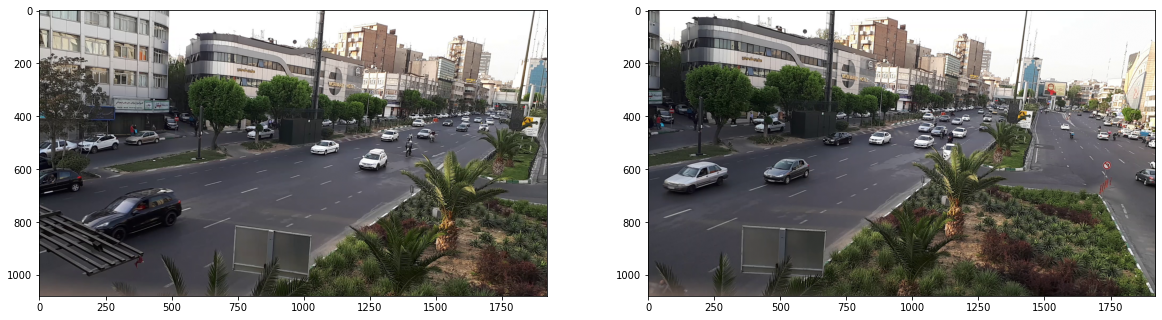

In [7]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time
from skimage import util, color, draw
from scipy.ndimage import gaussian_filter1d


video_path = './video.mp4'
use_gpu = False


def get_frame(video_cap, f_num):
    video_cap.set(cv.CAP_PROP_POS_FRAMES, f_num)
    return video_cap.read()[1]


def imshow(*srcs, bgr=True):
    plt.close()
    fig, ax = plt.subplots(ncols=len(srcs), figsize=(len(srcs) * 10, 10))
    for i, src in enumerate(srcs):
        if len(src.shape) == 3 and bgr:
            src = src[..., ::-1]
        t = (src - src.min()) / (src.max() - src.min())
        if (len(srcs)) > 1:
            ax[i].imshow(t, cmap='gray')
        else:
            ax.imshow(t, cmap='gray')
    plt.show()

cap = cv.VideoCapture(video_path)
imshow(get_frame(cap, 270), get_frame(cap, 450))
cap.release()


## Loading All Frames

حال ۹۰۰ فریم اول را در رانتایم لود می‌کنیم

In [8]:
cap = cv.VideoCapture(video_path)

all_frames = []
while cap.isOpened() and len(all_frames) < 900:
    ret, frame = cap.read()
    if not ret:
        break
    all_frames.append(frame)
cap.release()

900 (1080, 1920, 3)


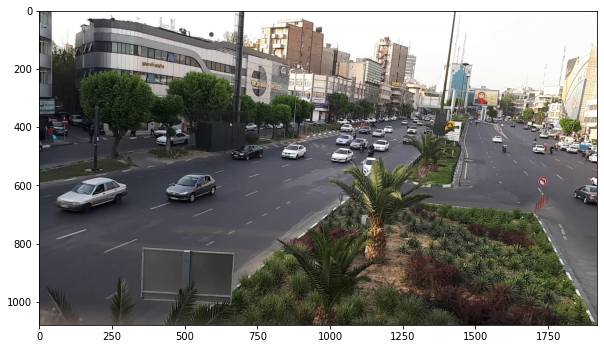

In [ ]:
print(len(all_frames), all_frames[0].shape)
imshow(all_frames[450])

## Homography

در ادامه کد پیدا کردن هوموگرافی به فریم اصلی آمده است. ابتدا یک تابع کمکی برای پیدا کردن هوموگرافی می‌سازیم که با توجه به انتخاب ما، یا با سی‌پی‌یو و یا با کارت گرافیکی این عمل را برای ما انجام دهد

عمل پیدا کردن ماتریس هوموگرافی، ابتدا با پیدا کردن اینترست پوینت‌های $SURF$ شروع می‌شود  
سپس این نقاط بر اساس ویژگی‌هایشان با $knn$
مچ می‌شوند و دو تای نزدیک‌تر انتخاب می‌شوند. همانند تمرین قبل اگر تفاوت این دو نقظه به ندازه کافی بود، آن‌را به عنوان مچ خوب در نظر می‌گیریم

در نهایت با استفاده از رنسک، نقاط به دست آمده را روی یک هوموگرافی فیت میکنیم

همچنین با توجه به نویز سنسور دوربین، بهتر است پیش از شروع، تصویر را کوچک‌تر کنیم تا نقاط اینترست پوینت بهتری به دست آید و در نهایت هوموگرافی به دست‌ آمده را اسکیل می‌کنیم

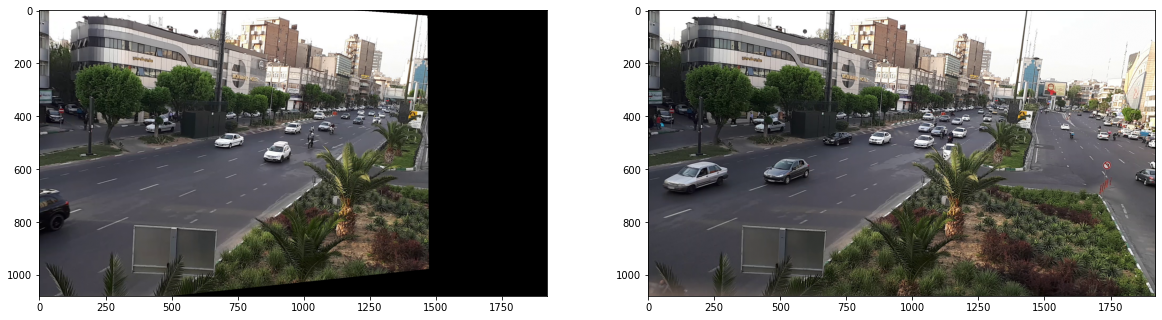

In [12]:
def find_homography(img1, img2, match_ratio_threshold=0.8, surf_hessian=400, gpu=False, down_scale=0.5):
    if gpu:
        gpu_img1 = cv.cuda_GpuMat(img1)
        gpu_img2 = cv.cuda_GpuMat(img2)

        gpu_img1 = cv.cuda.resize(gpu_img1, (0, 0), gpu_img1, down_scale, down_scale, interpolation=cv.INTER_AREA)
        gpu_img2 = cv.cuda.resize(gpu_img2, (0, 0), gpu_img2, down_scale, down_scale, interpolation=cv.INTER_AREA)

        gpu_img1 = cv.cuda.cvtColor(gpu_img1, cv.COLOR_BGR2GRAY)
        gpu_img2 = cv.cuda.cvtColor(gpu_img2, cv.COLOR_BGR2GRAY)

        surf_gpu = cv.cuda.SURF_CUDA_create(surf_hessian)
        matcher = cv.cuda.DescriptorMatcher_createBFMatcher(cv.NORM_L2)

        kp1_gpu, des1 = surf_gpu.detectWithDescriptors(gpu_img1, None)
        kp2_gpu, des2 = surf_gpu.detectWithDescriptors(gpu_img2, None)

        matches = matcher.knnMatch(des1, des2, k=2)

        kp1 = cv.cuda_SURF_CUDA.downloadKeypoints(surf_gpu, kp1_gpu)
        kp2 = cv.cuda_SURF_CUDA.downloadKeypoints(surf_gpu, kp2_gpu)

        matches = [m1 for m1, m2 in matches if m1.distance < match_ratio_threshold * m2.distance]
    else:
        algo = cv.xfeatures2d.SURF_create()

        img1 = cv.resize(img1, (0, 0), img1, down_scale, down_scale, interpolation=cv.INTER_AREA)
        img2 = cv.resize(img2, (0, 0), img2, down_scale, down_scale, interpolation=cv.INTER_AREA)

        kp1, des1 = algo.detectAndCompute(img1, None)
        kp2, des2 = algo.detectAndCompute(img2, None)

        matches = cv.BFMatcher(cv.NORM_L2).knnMatch(des1, des2, k=2)
        matches = [m1 for m1, m2 in matches if m1.distance < match_ratio_threshold * m2.distance]

    img1_final_points = np.float32([kp1[m.queryIdx].pt for m in matches])
    img2_final_points = np.float32([kp2[m.trainIdx].pt for m in matches])

    M, mask = cv.findHomography(img1_final_points, img2_final_points, cv.RANSAC,
                                ransacReprojThreshold=3,
                                maxIters=500000,
                                confidence=0.995)

    cnv = np.array([[down_scale, 0, 0], [0, down_scale, 0], [0, 0, 1]])
    cnvi = np.array([[1 / down_scale, 0, 0], [0, 1 / down_scale, 0], [0, 0, 1]])
    return cnvi @ M @ cnv


حال هوموگرافی را برای تمام فریم‌ها، به فریم ۴۵۰ حساب می‌کنیم. برای این‌کار ابتدا فریم‌های کلیدی را همانطور که در صورت تمرین گفته شده حساب میکنیم. سپس هر فریم را به نزدیک‌ترین فریم کلیدی می‌بریم و در هوموگرافی فریم کلیدی ضرب می‌کنیم

In [14]:
homo_to_450 = np.zeros((900, 3, 3))
homo_to_450[450] = np.eye(3)

key_frames_dist = 180

for i in range(450, 900, 180)[1:]:
    stp = (i - 450 - 1) % key_frames_dist + 1
    print('\b' * 20, i, stp, i - stp)
    homo_to_450[i] = find_homography(all_frames[i], all_frames[i - stp], gpu=use_gpu) @ homo_to_450[i - stp]

for i in range(450, -1, -180)[1:]:
    stp = (450 - i - 1) % key_frames_dist + 1
    print('\b' * 20, i, stp, i + stp)
    homo_to_450[i] = find_homography(all_frames[i], all_frames[i + stp], gpu=use_gpu) @ homo_to_450[i + stp]

for i in range(900):
    stp = (i - 450 + key_frames_dist//2) % key_frames_dist - key_frames_dist // 2
    ref = i-stp
    print('\b' * 20, i, stp, ref)
    homo_to_450[i] = find_homography(all_frames[i], all_frames[ref], gpu=use_gpu) @ homo_to_450[ref]

 630 180 450
 810 180 630
 270 180 450
 90 180 270
 0 -90 90
 1 -89 90
 2 -88 90
 3 -87 90
 4 -86 90
 5 -85 90
 6 -84 90
 7 -83 90
 8 -82 90
 9 -81 90
 10 -80 90
 11 -79 90
 12 -78 90
 13 -77 90
 14 -76 90
 15 -75 90
 16 -74 90
 17 -73 90
 18 -72 90
 19 -71 90
 20 -70 90
 21 -69 90
 22 -68 90
 23 -67 90
 24 -66 90
 25 -65 90
 26 -64 90
 27 -63 90


## Part 1

برای این قسمت یک مستطیل را نقاط گوشه‌ها توصیف می‌کنیم و در فریم ۴۵۰ رسم می‌کنیم. سپس هر نقظه را با وارون هوموگرافی به دست‌ آمده از قسمت قبل به فریم ۲۷۰ می‌بریم و رسم می‌کنیم۰

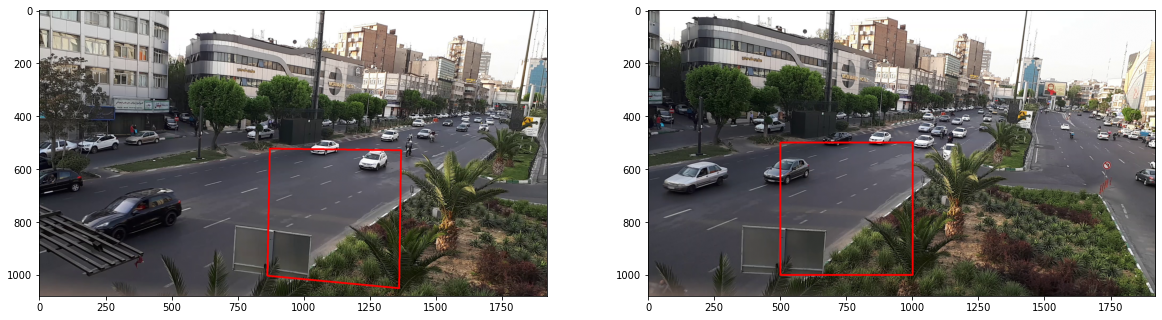

True

In [15]:
frame450_rect = all_frames[450].copy()
frame270_rect = all_frames[270].copy()
rect_pts = np.array([[500, 500], [1000, 500], [1000, 1000], [500, 1000]], dtype=np.int32).reshape((-1, 1, 2))
cv.polylines(frame450_rect, [rect_pts], True, (0, 0, 255), thickness=5)
rect_pts = cv.perspectiveTransform(rect_pts.astype(np.float32), np.linalg.inv(homo_to_450[270])).astype(np.int32)
cv.polylines(frame270_rect, [rect_pts], True, (0, 0, 255), thickness=5)
imshow(frame270_rect, frame450_rect)
cv.imwrite('res01-450-rect.jpg',frame450_rect)
cv.imwrite('res02-270-rect.jpg',frame270_rect)


در ادامه، ابتدا یک تابع کمکی برای وارپ کردن تصویر تعریف می‌کنیم که بین استفاده از جی‌پی‌یو یا سی‌پی‌یو سوییچ کند۰  

سپس یک تابع کمکی تعریف می‌کنیم که یک $Bounding Box$
برای فریم ‌های تبدیل شده در هوموگرافی پیدا کند تا بتوانیم به راحتی انتقال‌‌های لازم را روی فریم‌های وارپ شده با هوموگرافی اعمال کنیم تا همه فریم‌ها در قاب نهاییی قابل رویت باشند. این تابع یک ماتریس انتقال و یک سایز قاب نهایی خروجی می‌دهد که کافی‌ست ماتریس انتقال را در هموگرفی‌های هر فریم ضرب چپ کنیم تا در فریم‌نهایی قرار گیرند  
به طور دقیق‌تر این تابع نقاط گوشه‌های هر فریم را تحت هموگرفی هر فریم انتقال می‌دهد و یک ماتریس انتقال برای صفر کردن کمینه و یک سایز که بر اساس اختلاف کمینه و بیشینه نقاط است خروجی می‌دهد۰

در نهایت دو فریم ۴۵۰ و ۲۷۰ را در یک قاب قرار می‌دهیم و نمایش می‌دهیم۰

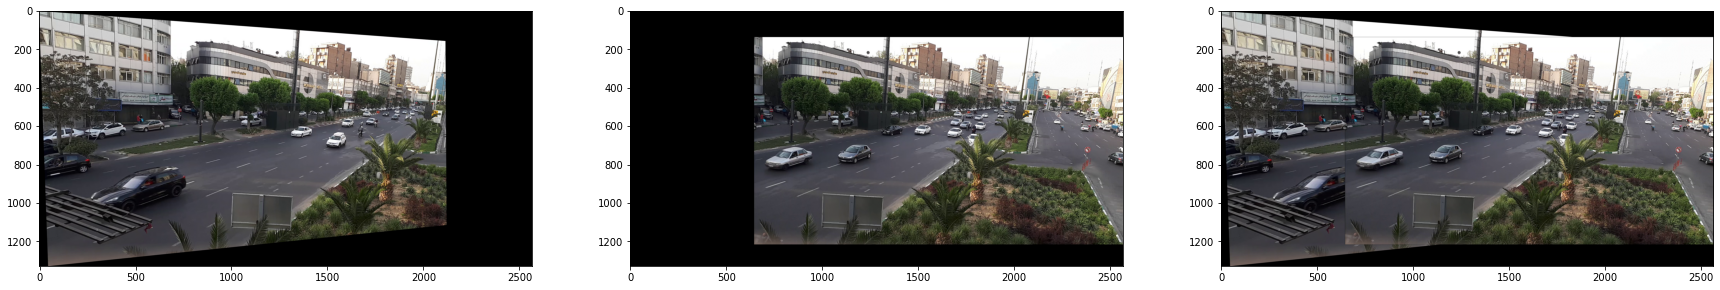

True

In [16]:
def warp_perspective(src, mat, sz, gpu=False, flt=True):
    res = None
    if gpu:
        src = util.img_as_ubyte(src)
        gpu_imgt = cv.cuda_GpuMat(src)
        tmp = cv.cuda.warpPerspective(gpu_imgt, mat, sz)
        res = tmp.download()
    else:
        res = cv.warpPerspective(src, mat, sz)
    if flt:
        return util.img_as_float64(res)
    else:
        return res


def find_bounding_frame(mats, frame_size):  # frame size = (w,h)
    predicted_points = []
    w, h = frame_size
    src_points = np.float32([[0, 0], [0, h], [w, h], [w, 0]])
    for mat in mats:
        t = cv.perspectiveTransform(src_points.reshape(-1, 1, 2), mat).reshape(src_points.shape)
        predicted_points.append(t)
    predicted_points = np.concatenate(tuple(predicted_points))
    pts_min = np.min(predicted_points, axis=0)
    pts_max = np.max(predicted_points, axis=0)
    pts_diff = np.int64(pts_max - pts_min)
    mat_t = np.array([[1, 0, -pts_min[0]], [0, 1, -pts_min[1]], [0, 0, 1]])
    return tuple(pts_diff), mat_t


h, w = all_frames[0].shape[:2]

p_diff, M_t = find_bounding_frame(homo_to_450[[450, 270]], (w, h))
M_p = (M_t @ homo_to_450[270])

df_mask = np.ones_like(all_frames[450]) * 255

f270_warped = warp_perspective(all_frames[270], M_p, p_diff,False,False)
f450_warped = warp_perspective(all_frames[450], M_t, p_diff,False,False)
f450_mask_warped = warp_perspective(df_mask, M_t, p_diff,False,False) > 0.8

tmp3 = f270_warped.copy()
tmp3[f450_mask_warped] = f450_warped[f450_mask_warped]

imshow(f270_warped, f450_warped, tmp3)
cv.imwrite('res03-270-450-panorama.jpg', tmp3)


## Part 2

در این قسمت، برای ادغام این پنج فریم، ابتدا همه را در یک قاب، با استفاده از توابع قسمت قبل، قرار می‌دهیم. سپس برای ادغام آن‌ها، از $MultiBandBlending$
و پیدا کردن خط کمترین اختلاف با استفاده از برنامه ریزی پویا که در ترم قبل گفته شدند، استفاده می‌کنیم۰  

برای هر دو فریم متوالی، خط برش دهنده با کمترین اختلاف را در نوار اشتراک دو فریم، پیدا می‌کنیم. سپس بر اساس آن یک ماسک می‌سازیم و با ماسک، دو فریم را در فرکانس‌های مختلف ترکیب می‌کنیم که در حقیقت همان استفاده از هرم لاپلاسین و فدرینگ است۰

In [17]:
def multi_band_blending(img1, img2, mask,
                        iterations=5,
                        m_ratio=0.8,
                        bandwidth_low=10,
                        bandwidth_high=20,
                        m_cutoff=12):
    def pyr_up(src, cutoff, ratio):
        lowpassed = cv.GaussianBlur(src, (2 * cutoff + 1, 2 * cutoff + 1), 0,
                                    borderType=cv.BORDER_REFLECT101)
        src -= lowpassed
        return cv.resize(lowpassed, (0, 0), None, ratio, ratio, cv.INTER_AREA)

    def blend(src, tar, mask, bandwidth):
        mask = cv.GaussianBlur(mask, (2 * bandwidth + 1, 2 * bandwidth + 1), 0
                               , borderType=cv.BORDER_REFLECT101)[:, :, None]
        return src * mask + tar * (1 - mask)

    if len(mask.shape) == 3:
        mask = color.rgb2gray(mask)

    pyr_lap_1 = [util.img_as_float64(img1, force_copy=True)]
    pyr_lap_2 = [util.img_as_float64(img2, force_copy=True)]
    pyr_mask = [util.img_as_float64(mask, force_copy=True)]

    for i in range(iterations):
        pyr_lap_1.append(pyr_up(pyr_lap_1[i], m_cutoff, m_ratio))
        pyr_lap_2.append(pyr_up(pyr_lap_2[i], m_cutoff, m_ratio))
        pyr_mask.append(cv.resize(pyr_mask[i], (0, 0), None, m_ratio, m_ratio, cv.INTER_NEAREST))

    pyr_lap_1[iterations] = blend(pyr_lap_1[iterations], pyr_lap_2[iterations], pyr_mask[iterations], bandwidth_low)

    for i in range(iterations - 1, -1, -1):
        pyr_lap_1[i] = blend(pyr_lap_1[i], pyr_lap_2[i], pyr_mask[i], bandwidth_high)
        tmp = cv.resize(pyr_lap_1[i + 1], pyr_lap_1[i].shape[:2][::-1], interpolation=cv.INTER_AREA)
        pyr_lap_1[i] += tmp

    res = np.clip(pyr_lap_1[0], 0, 1)
    return res


def get_mag(src):
    src = src ** 2
    res = np.zeros(src.shape[:2])
    if len(src.shape) > 2:
        for i in range(3):
            res += src[:, :, i]
        res /= 3
    else:
        res += src
    res = np.sqrt(res)
    return res


def find_shortest_path(mat, spr=1, diag=1):
    dp = np.ones_like(mat) * 1000000000
    dp_arg = np.ones(mat.shape, dtype=int) * -1
    dp[0, :] = 0
    dp_arg[0, :] = -1
    for i in range(1, mat.shape[0]):
        print('\b' * 20, i)
        for j in range(mat.shape[1]):
            for j2 in range(max(0, j - spr), min(mat.shape[1], j + spr + 1)):
                dist = 0
                if abs(j - j2) > diag:
                    pass
                else:
                    dist = dp[i - 1, j2] + mat[i - 1, j2]
                if dist < dp[i, j]:
                    dp[i, j] = dist
                    dp_arg[i, j] = j2
    arg_mn = np.argmin(dp[-1, :])
    arg_i = mat.shape[0] - 1
    res = [(arg_i, arg_mn)]
    while arg_i > 0:
        arg_mn = dp_arg[arg_i, arg_mn]
        arg_i -= 1
        res.append((arg_i, arg_mn))
    res.reverse()
    return np.array(res)


def get_shortest_path_mask(mat, spr=1, diag=1, ker_prep=5):
    print(mat.shape)
    mat = cv.GaussianBlur(mat, (ker_prep, ker_prep), 0)
    verts = find_shortest_path(mat, spr, diag)
    verts = np.concatenate((verts, [[mat.shape[0], 0], [0, 0]]), axis=0)
    return draw.polygon2mask(mat.shape[:2], verts)


def get_overlap_mask(img1, img2):
    img1_mask = 1.0 * (img1 > 0.001)
    img2_mask = 1.0 * (img2 > 0.001)

    kernel = np.ones((25, 25), np.uint8)
    img1_mask = cv.morphologyEx(img1_mask, cv.MORPH_CLOSE, kernel, iterations=1)
    img2_mask = cv.morphologyEx(img2_mask, cv.MORPH_CLOSE, kernel, iterations=1)

    overlap = img1_mask * img2_mask
    return overlap, img1_mask, img2_mask


def find_optimal_mask(img1, img2):
    img1 = util.img_as_float64(img1, force_copy=True)
    img2 = util.img_as_float64(img2, force_copy=True)

    overlap, img1_mask, img2_mask = get_overlap_mask(img1, img2)

    ag = np.argwhere(overlap)
    bound_min = np.min(ag, axis=0)
    bound_max = np.max(ag, axis=0)
    conf_dist = (bound_max[1] - bound_min[1]) // 20

    diff_mag = get_mag(img1 - img2)
    diff_mag[:, bound_min[1]:bound_min[1] + conf_dist] = 1
    diff_mag[:, bound_max[1] - conf_dist:bound_max[1]] = 1

    msk_ovr = 1 - 1.0 * get_shortest_path_mask(diff_mag[:, bound_min[1]:bound_max[1]])
    msk = 1.0 * img2_mask
    msk[:, bound_min[1]:bound_max[1]] *= msk_ovr[..., None]

    return msk


Streaming output truncated to the last 5000 lines.
 1573
 1574
 1575
 1576
 1577
 1578
 1579
 1580
 1581
 1582
 1583
 1584
 1585
 1586
 1587
 1588
 1589
 1590
 1591
 1592
 1593
 1594
 1595
 1596
 1597
 1598
 1599
 1600
 1601
 1602
 1603
 1604
 1605
 1606
 1607
 1608


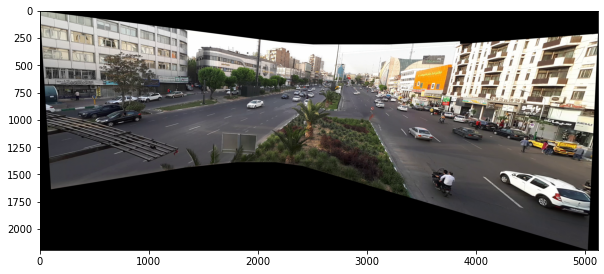

True

In [18]:
h, w = all_frames[0].shape[:2]
key_frame_idx = [90, 270, 450, 630, 810]
p_diff, M_t = find_bounding_frame(homo_to_450[key_frame_idx], (w, h))

res04 = warp_perspective(all_frames[key_frame_idx[0]], np.matmul(M_t, homo_to_450[key_frame_idx[0]]), p_diff)

for idx in key_frame_idx[1:]:
    tmp = warp_perspective(all_frames[idx], np.matmul(M_t, homo_to_450[idx]), p_diff)
    mask_m = find_optimal_mask(res04, tmp)
    mask_overlap = get_overlap_mask(res04, tmp)[0]
    res04 = multi_band_blending(tmp, res04, mask_m) * mask_overlap + (res04 + tmp) * (1 - mask_overlap)
    del tmp
    del mask_m
    del mask_overlap

imshow(res04)
cv.imwrite('res04-key-frames-panorama.jpg', util.img_as_ubyte(res04))


## Part 3

در این قسمت، ابتدا فریم در بر گیرنده کل فریم‌ها را همانند قسمت‌های قبل به دست می‌آوریم و سپس هر فریم را با استفاده از هموگرفی‌های به دست آمده تبدیل می‌کنیم و در ویدیو خروجی می‌نویسیم۰

In [19]:
full_dim, M_t_full = find_bounding_frame(homo_to_450, (w, h))
vw = cv.VideoWriter('res05-reference-plane.mp4', cv.VideoWriter_fourcc(*'MP4V'), 30, full_dim)

for i,(frame, mat) in enumerate(zip(all_frames, homo_to_450)):
    vw.write(warp_perspective(frame, (M_t_full @ mat), full_dim, gpu=use_gpu, flt=False))
    print('\b'*20, i)
vw.release()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31
 32
 33
 34
 35
 36
 37
 38
 39
 40
 41


## Part 4

در این قسمت برای به دست آوردن پس‌زمینه، ابتدا به منظور استفاده کمتر از رم، تصویر نهایی را به نوار‌های باریک همودی تقسیم می‌کنیم و پس‌زمینه را جداگانه به ازای هرکدام به دست می‌آوریم و درنهایت این نوار‌ها را در کنار هم قرار می‌دهیم  

برای به دست‌آوردن پس‌زمینه، ابتدا فریم‌هایی که تمامن این نوار را شامل می‌شوند را به دست می‌آوریم(با بررسی نقاط گوشه‌ای فریم) سپس میانه آن‌ها را به ازای هر پیکسل دست می‌آوریم   

البته روش‌های دیگری برای تولید پس‌زمینه، همچون مد گیری با استفاده از روش شمارنده غالب و یا اینکه در همین روش قسمت‌هایی که تفاوت چندانی با فریم‌های اصلی ندارند را از یک فریم‌خاص بیاوریم را امتحان کردم ولی هیچکدام به خوبی ساده‌ترین روش عمل نکردند! ـ

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31
 32
 33
 34
 35
 36
 37
 38
 39
 40
 41


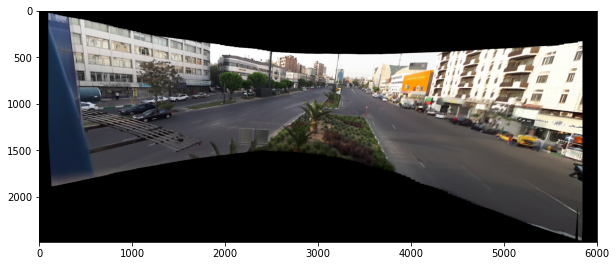

In [ ]:
def get_frame_corners(mat, sz):  # sz = (w,h)
    src_points = np.float32([[0, 0], [0, h], [w, h], [w, 0]])
    dst_points = cv.perspectiveTransform(src_points.reshape(-1, 1, 2), mat).reshape(src_points.shape)
    return dst_points


strip_width = 50
full_dim, M_t_full = find_bounding_frame(homo_to_450, (w, h))
res06 = np.zeros((full_dim[1], full_dim[0], 3), dtype=np.uint8)

for t in range((full_dim[0] + strip_width - 1) // strip_width):
    x_min = strip_width * t
    x_max = min(strip_width * (t + 1), full_dim[0])
    print('\b'*20, t)
    fr_idx = []
    fr_idx_full = []
    for i, mat in enumerate(homo_to_450):
        corners = get_frame_corners(np.matmul(M_t_full, mat), (w, h))
        if corners[0, 0] <= x_min and corners[1, 0] <= x_min and corners[2, 0] >= x_max and corners[3, 0] >= x_max - 200:
            fr_idx.append(i)
        if corners[0, 0] <= x_max and corners[1, 0] <= x_max and corners[2, 0] >= x_min and corners[3, 0] >= x_min - 200:
            fr_idx.append(i)

    if len(fr_idx) == 0:
        fr_idx = fr_idx_full
        if len(fr_idx) == 0:
            continue
    
    fr_stack = np.zeros((len(fr_idx), full_dim[1], x_max - x_min, 3), dtype=np.uint8)

    for i, idx in enumerate(fr_idx):
        mat = homo_to_450[idx]
        frame = all_frames[idx]
        tr = warp_perspective(frame,
                              np.matmul(np.array([[1, 0, -x_min], [0, 1, 0], [0, 0, 1]]), np.matmul(M_t_full, mat)),
                              (x_max - x_min, full_dim[1]), flt=False)
        fr_stack[i, ...] = tr
        del tr

    med = np.median(fr_stack, axis=0).astype(np.uint8)
    res06[:, x_min:x_max, :] = med
    del fr_stack,med


imshow(res06)
cv.imwrite('res06-background-panorama.jpg', res06)


## Part 5

برای به دست آوردن ویدیو از پس‌زمینه، کافی‌ست همان هموگرافی‌هایی که برای تولید قسمت ۳ استفاده کردیم را معکوس کرده و روی ریزالت قسمت قبل اعمال کنیم تا فریم‌هایی در مختصات اولیه تولید شوند۰

In [ ]:
res06 = cv.imread('res06-background-panorama.jpg')

_, M_t_full = find_bounding_frame(homo_to_450, (w, h))
vw = cv.VideoWriter('res07-background-video.mp4', cv.VideoWriter_fourcc(*'MP4V'), 30, (w,h))
for i,mat in enumerate(homo_to_450):
    vw.write(warp_perspective(res06, np.linalg.inv((M_t_full @ mat)), (w,h), gpu=use_gpu, flt=False))
    print('\b'*10, i)
vw.release()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31
 32
 33
 34
 35
 36
 37
 38
 39
 40
 41
 42
 43
 44
 45
 46
 47
 48
 49
 50
 51
 52
 53
 54
 55
 56
 57
 58
 59
 60
 61
 62
 63
 64
 65
 66
 67
 68
 69
 70
 71
 72
 73
 74
 75
 76
 77
 78
 79
 80
 81
 82
 83
 84
 85
 86
 87
 88
 89
 90
 91
 92
 93
 94
 95
 96
 97
 98
 99
 100
 101
 102
 103
 104
 105
 106
 107
 108
 109
 110


## Part 6

برای به دست‌آوردن ماسک فورگراند، هر فریم اصلی را با فریم معادلش در ویدیو پس زمینه مقایسه می‌کنیم و همانطور که در صورت تمرین گفته شده، با یک ترشهولد، جاهایی که اختلاف رنگ با پس‌زمینه زیاد است را به عنوان پیش‌زمینه اعلام می‌کنیم  

برای حذف نویز، از مورفولوژی اپنینگ روی ماسک ابتدا استفاده می‌کنیم تا مجموعه پیکسل‌های کوچک نویز‌گونه، از بین بروند و سپس یک کلوزینگ با کرنل بزرگ اعمال می‌کنیم تا همبندی برای قطعات نزدیک به هم احتمالا مربوط به یک جسم هستند، فورس شود  

گرچه برای اندازه‌گیری فاصله رنگی می‌توانستیم از فضاهای رنگی دیگری همچون $HSV$
استفاده کنیم ولی نتیجه چندان مطلوب نبود

In [ ]:
res06 = cv.imread('res06-background-panorama.jpg')
thresh = 3*20
kernel = lambda x: np.ones((x,x),dtype=np.uint8)
fn = 270

_, M_t_full = find_bounding_frame(homo_to_450, (w, h))
vw = cv.VideoWriter('res08-foreground-video.mp4', cv.VideoWriter_fourcc(*'MP4V'), 30, (w,h))

for i,(frame, mat) in enumerate(zip(all_frames, homo_to_450)):
    bg = warp_perspective(res06, np.linalg.inv((M_t_full @ mat)), (w,h), gpu=use_gpu, flt=False)
    bg_mag = np.linalg.norm(bg,axis=2)
    
    diff = frame.astype(np.int16) - bg.astype(np.int16)
    diff_mag = np.linalg.norm(diff,axis=2)

    mask = ((diff_mag > thresh) & (bg_mag > 1)).astype(np.uint8)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel(9))
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel(25))

    frame = frame.copy()
    frame[mask > 0] = (frame[mask > 0] + np.array([0,0,255]))//2

    vw.write(frame)
    print('\b'*10, i)

vw.release()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31
 32
 33
 34
 35
 36
 37
 38
 39
 40
 41
 42
 43
 44
 45
 46
 47
 48
 49
 50
 51
 52
 53
 54
 55
 56
 57
 58
 59
 60
 61
 62
 63
 64
 65
 66
 67
 68
 69
 70
 71
 72
 73
 74
 75
 76
 77
 78
 79
 80
 81
 82
 83
 84
 85
 86
 87
 88
 89
 90
 91
 92
 93
 94
 95
 96
 97
 98
 99
 100
 101
 102
 103
 104
 105
 106
 107
 108
 109
 110


## Part 7

برای این قمست نیز کمابیش همان راه‌حل قسمت ۵ را داریم؛ با این تفاوت که کافی‌ست سایز فریم نهایی را بزرگ‌تر بگیریم تا با وارپ تصویر، قسمت‌های بیشتری نمایان شود۰

In [ ]:
res06 = cv.imread('res06-background-panorama.jpg')

_, M_t_full = find_bounding_frame(homo_to_450, (w,h))
full_dim = (int(w*1.5), h)

vw = cv.VideoWriter('res09-background-video-wider.mp4', cv.VideoWriter_fourcc(*'MP4V'), 30, full_dim)
for i,mat in enumerate(homo_to_450):
    vw.write(warp_perspective(res06, np.linalg.inv((M_t_full @ mat)), full_dim, gpu=use_gpu, flt=False))
    print('\b'*10, i)
vw.release()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31
 32
 33
 34
 35
 36
 37
 38
 39
 40
 41
 42
 43
 44
 45
 46
 47
 48
 49
 50
 51
 52
 53
 54
 55
 56
 57
 58
 59
 60
 61
 62
 63
 64
 65
 66
 67
 68
 69
 70
 71
 72
 73
 74
 75
 76
 77
 78
 79
 80
 81
 82
 83
 84
 85
 86
 87
 88
 89
 90
 91
 92
 93
 94
 95
 96
 97
 98
 99
 100
 101
 102
 103
 104
 105
 106
 107
 108
 109
 110


## Part 8

برای این قسمت، از آنجایی که درایه‌های ماتریس هوموگرافی در طی فریم‌ها به صورت پیوسته تغییر می‌کند، می‌توانیم فرض کنیم در صورت نبود لرزش، به صورت اسموت و بدون تغییرات ناگهانی تغییر می‌کند. پس برای کاهش لرزش ابتدا هر فریم را با هموگرافی اصلی به مختصات فریم مرجع می‌بریم سپس با وارون هموگرافی اسموت شده، به مختصات خود فریم باز می‌گردیم. روش به دست آوردن هموگرافی اسموت شده، اعمال یک کرنل گاوسی روی درایه‌های ماتریس‌ها در امتداد محور زمان است۰  

روش دیگری که امتحان کردم، تجزیه هموگرافی با $SVD$
و اسموت کردن درایه‌های مربوط به چرخش و به طور جداگانه اسموت کردن درایه‌های مربوط به انتقال در امتداد محور زمان بود که به هیچ‌وجه ریزالت قابل‌توجهی به دست نیامد! ـ

In [ ]:
homo_smt = homo_to_450.copy()

for i in range(3):
    for j in range(3):
        homo_smt[:,i,j] = gaussian_filter1d(homo_smt[:,i,j],5)

for i in range(900):
    homo_smt[i] = np.linalg.inv(homo_smt[i]) @ homo_to_450[i]

vw = cv.VideoWriter('res10-video-shakeless.mp4', cv.VideoWriter_fourcc(*'MP4V'), 30, (w,h))
for i,(frame, mat) in enumerate(zip(all_frames, homo_smt)):
    vw.write(warp_perspective(frame, mat, (w,h), gpu=use_gpu, flt=False))
    print('\b'*10, i)
vw.release()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31
 32
 33
 34
 35
 36
 37
 38
 39
 40
 41
 42
 43
 44
 45
 46
 47
 48
 49
 50
 51
 52
 53
 54
 55
 56
 57
 58
 59
 60
 61
 62
 63
 64
 65
 66
 67
 68
 69
 70
 71
